In [17]:
import os
import requests
import bs4 as bs
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
from matplotlib import style
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import pandas_datareader.data as web

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    with open("sp500tickers.pickle", 'wb') as f:
        pkl.dump(tickers, f)
    return tickers
# save_sp500_tickers()

In [3]:
def get_data_from(reload_sp500=False):
    print("Getting stock data of companies in SP500 list")
    print("Mining..............")
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", 'rb') as f:
            tickers = pkl.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    
    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2016, 12, 31)
    for ticker in tickers:
        print("  == Acquiring {} data".format(ticker))
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except:
                df = web.DataReader(ticker, 'google', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print("   - Already have {}".format(ticker))
    print("DONE")
get_data_from()

Getting stock data of companies in SP500 list
Mining..............
  == Acquiring MMM data
   - Already have MMM
  == Acquiring ABT data
   - Already have ABT
  == Acquiring ABBV data
   - Already have ABBV
  == Acquiring ACN data
   - Already have ACN
  == Acquiring ATVI data
   - Already have ATVI
  == Acquiring AYI data
   - Already have AYI
  == Acquiring ADBE data
   - Already have ADBE
  == Acquiring AMD data
   - Already have AMD
  == Acquiring AAP data
   - Already have AAP
  == Acquiring AES data
   - Already have AES
  == Acquiring AET data
   - Already have AET
  == Acquiring AMG data
   - Already have AMG
  == Acquiring AFL data
   - Already have AFL
  == Acquiring A data
   - Already have A
  == Acquiring APD data
   - Already have APD
  == Acquiring AKAM data
   - Already have AKAM
  == Acquiring ALK data
   - Already have ALK
  == Acquiring ALB data
   - Already have ALB
  == Acquiring ARE data
   - Already have ARE
  == Acquiring AGN data
   - Already have AGN
  == Acqu

In [5]:
def compile_data():
    with open("sp500tickers.pickle", 'rb') as f:
        tickers = pkl.load(f)
    main_df = pd.DataFrame()
    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        df.rename(columns={'Adj Close':ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
        if count % 100 == 0:
            print("{}: {}".format(count, ticker))
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
compile_data()

0: MMM
100: CHTR
200: F
300: MJN
400: CRM
500: YHOO
                  MMM       ABT  ABBV  ACN      ATVI  AYI       ADBE     AMD  \
Date                                                                           
2000-01-03  31.131128  9.517434   NaN  NaN  1.259640  NaN  16.274673  15.500   
2000-01-04  29.894130  9.245507   NaN  NaN  1.221324  NaN  14.909400  14.625   
2000-01-05  30.760029  9.228512   NaN  NaN  1.226114  NaN  15.204175  15.000   
2000-01-06  33.234026  9.551425   NaN  NaN  1.202166  NaN  15.328291  16.000   
2000-01-07  33.893758  9.653397   NaN  NaN  1.235693  NaN  16.072985  16.250   

            AAP        AES ...        XEL        XRX       XLNX         XL  \
Date                       ...                                               
2000-01-03  NaN  32.346420 ...   8.593504  12.447396  35.497325  32.099796   
2000-01-04  NaN  31.063717 ...   8.791381  11.868447  34.690567  30.654915   
2000-01-05  NaN  31.398335 ...   9.130598  12.479560  33.931266  30.928271 

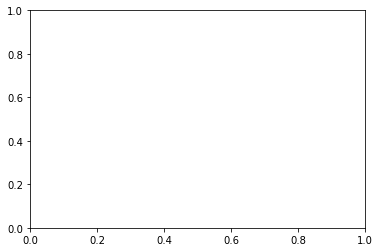

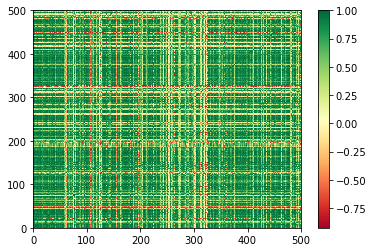

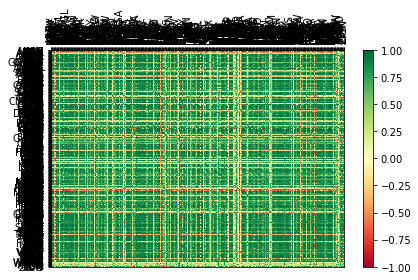

In [9]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
#     print(df_corr.head)
    df_corr.to_csv('sp500corr.csv')
    
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)
    ax1.set_xticks(np.arange(data1.shape[0] + 0.5), minor=False)
    ax1.set_yticks(np.arange(data1.shape[1] + 0.5), minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()
visualize_data()

In [13]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace = True)
    for i in range(1, hm_days + 1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    return tickers, df
process_data_for_labels('GOOGL')

(['MMM',
  'ABT',
  'ABBV',
  'ACN',
  'ATVI',
  'AYI',
  'ADBE',
  'AMD',
  'AAP',
  'AES',
  'AET',
  'AMG',
  'AFL',
  'A',
  'APD',
  'AKAM',
  'ALK',
  'ALB',
  'ARE',
  'AGN',
  'LNT',
  'ALXN',
  'ALLE',
  'ADS',
  'ALL',
  'GOOGL',
  'GOOG',
  'MO',
  'AMZN',
  'AEE',
  'AAL',
  'AEP',
  'AXP',
  'AIG',
  'AMT',
  'AWK',
  'AMP',
  'ABC',
  'AME',
  'AMGN',
  'APH',
  'APC',
  'ADI',
  'ANTM',
  'AON',
  'APA',
  'AIV',
  'AAPL',
  'AMAT',
  'ADM',
  'ARNC',
  'AJG',
  'AIZ',
  'T',
  'ADSK',
  'ADP',
  'AN',
  'AZO',
  'AVB',
  'AVY',
  'BHI',
  'BLL',
  'BAC',
  'BK',
  'BCR',
  'BAX',
  'BBT',
  'BDX',
  'BBBY',
  'BBY',
  'BIIB',
  'BLK',
  'HRB',
  'BA',
  'BWA',
  'BSX',
  'BMY',
  'AVGO',
  'CHRW',
  'CA',
  'COG',
  'CPB',
  'COF',
  'CAH',
  'CBOE',
  'KMX',
  'CCL',
  'CAT',
  'CBG',
  'CBS',
  'CELG',
  'CNC',
  'CTL',
  'CERN',
  'CF',
  'SCHW',
  'CHTR',
  'CHK',
  'CVX',
  'CMG',
  'CB',
  'CHD',
  'CI',
  'XEC',
  'CINF',
  'CTAS',
  'CSCO',
  'C',
  'CFG',
  'CT

In [26]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.04
    for col in cols:
        if col > requirement:
            return 1
        if col < - requirement:
            return -1
    return 0

def extract_features(ticker):
    tickers, df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)]=list(map(buy_sell_hold ,
                                           df['{}_1d'.format(ticker)],
                                           df['{}_2d'.format(ticker)],
                                           df['{}_3d'.format(ticker)],
                                           df['{}_4d'.format(ticker)],
                                           df['{}_5d'.format(ticker)],
                                           df['{}_6d'.format(ticker)],
                                           df['{}_7d'.format(ticker)]))
#     df['{}_target'.format(ticker)]=list(map(buy_sell_hold ,*[df['{}_{}d'.format(ticker, i)] for i in range(1, 8)]))
                                           
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))
    df.fillna(0, inplace=True)
    df=df.replace([np.inf, -np.inf], np.nan)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    X, y = df_vals.values, df['{}_target'.format(ticker)].values
    return X, y, df

extract_features('AMZN')
    

Data spread: Counter({'1': 1619, '-1': 1371, '0': 1287})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.03973508, -0.02857146,  0.        , ...,  0.        ,
         -0.04842343,  0.        ],
        [ 0.02896552, -0.00183819,  0.        , ...,  0.        ,
         -0.00118343,  0.        ],
        ..., 
        [-0.00469482, -0.00984448, -0.00367999, ...,  0.00155487,
         -0.01479631, -0.00521226],
        [ 0.00185311,  0.00235478,  0.00738717, ...,  0.00426938,
         -0.01132159,  0.00336827],
        [ 0.00089683,  0.00261025, -0.00175354, ..., -0.00289858,
          0.0058425 , -0.00167847]]),
 array([-1, -1, -1, ...,  0,  0,  0], dtype=int64),
                    MMM        ABT       ABBV         ACN       ATVI  \
 Date                                                                  
 2000-01-03   31.131128   9.517434   0.000000    0.000000   1.259640   
 2000-01-04   29.894130   9.245507   0.000000    0.000000   1.221324   
 2000-01-05   30.760029   9.2285

In [27]:
def do_ml(ticker):
    X, y, df = extract_features(ticker=ticker)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())])
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    print('Accurracy:', confidence)
do_ml('AMZN')

Data spread: Counter({'1': 1619, '-1': 1371, '0': 1287})
Predicted spread: Counter({-1: 500, 0: 305, 1: 265})
Accurracy: 0.408411214953
